In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, Adamax, Adadelta

from sklearn.metrics import classification_report, confusion_matrix

In [2]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


In [3]:
train = pd.read_csv("../input/Kannada-MNIST/train.csv")
test = pd.read_csv("../input/Kannada-MNIST/test.csv")

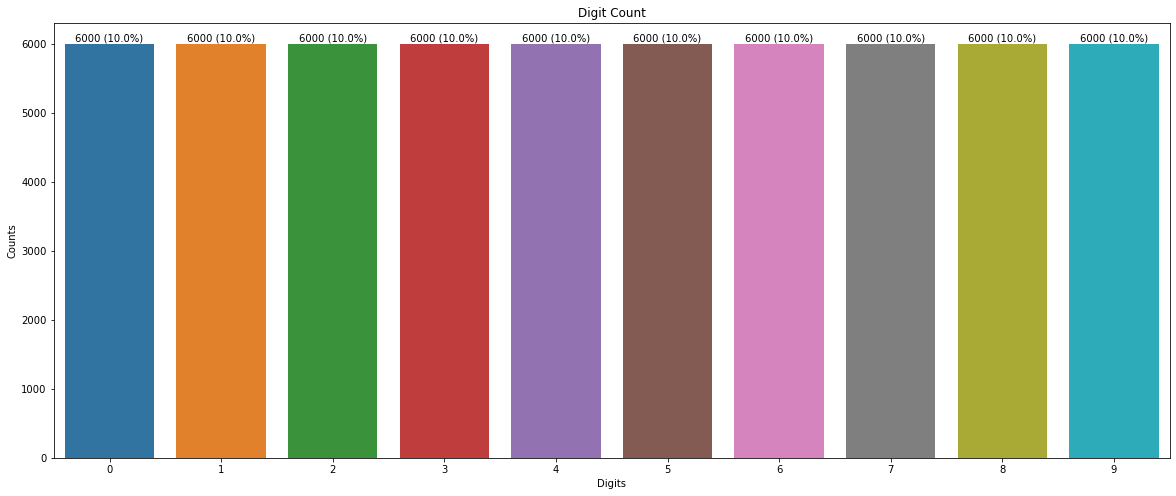

In [4]:
df_digit_counts =  train.label.value_counts().reset_index()

plt.figure(figsize=(20,8))
ax = sns.barplot(x='index', y='label', data=df_digit_counts)

for i in ax.patches:
    v1 = round((i.get_height()/len(train))*100, 2)
    ax.annotate(f'{int(i.get_height())} ({v1}%)', (i.get_x()+0.4, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Digit Count")
plt.ylabel("Counts")
plt.xlabel("Digits")
plt.show()

In [5]:
train_X, train_y = train.drop(columns=['label']), train["label"]

In [6]:
train_X = np.array(train_X)
train_y = np.array(train_y)

In [7]:
testx = test.drop(columns=['id'])

In [8]:
testx = np.array(testx)

In [9]:
train_X = train_X.reshape(-1,28,28,1)
testx = testx.reshape(-1,28,28,1)

In [10]:
train_X = train_X / 255.0
testx = testx / 255.0

In [11]:
train_y = to_categorical(train_y, num_classes = len(np.unique(train["label"])))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=42, stratify= train_y, shuffle=True)

In [13]:
epochs = 20
batch_size = 16

In [14]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(10, activation = "softmax"))
    
    return model

In [15]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

In [16]:
optimizer = Adamax()
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')



In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_test,y_test), 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[lr_reduction, es], 
                              shuffle=True)

Epoch 1/20
2812/2812 [==============================] - 29s 10ms/step - loss: 0.3841 - accuracy: 0.8754 - val_loss: 0.0588 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 2/20
2812/2812 [==============================] - 29s 10ms/step - loss: 0.1084 - accuracy: 0.9691 - val_loss: 0.0616 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 3/20
2812/2812 [==============================] - 28s 10ms/step - loss: 0.0730 - accuracy: 0.9804 - val_loss: 0.0250 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 4/20
2812/2812 [==============================] - 29s 10ms/step - loss: 0.0571 - accuracy: 0.9842 - val_loss: 0.0170 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 5/20
2812/2812 [==============================] - 28s 10ms/step - loss: 0.0480 - accuracy: 0.9868 - val_loss: 0.0157 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 6/20
2812/2812 [==============================] - 29s 10ms/step - loss: 0.0419 - accuracy: 0.9882 - val_loss: 0.0167 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 7/20
2812/2812 [========================

In [19]:
model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

469/469 [==============================] - 2s 3ms/step - loss: 0.0092 - accuracy: 0.9974


([0.005232048686593771, 0.9984222054481506],
 [0.009208550676703453, 0.9973999857902527])

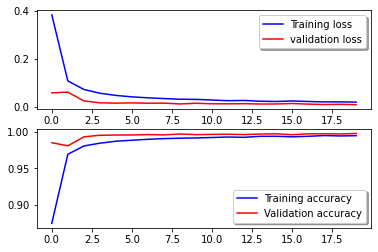

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

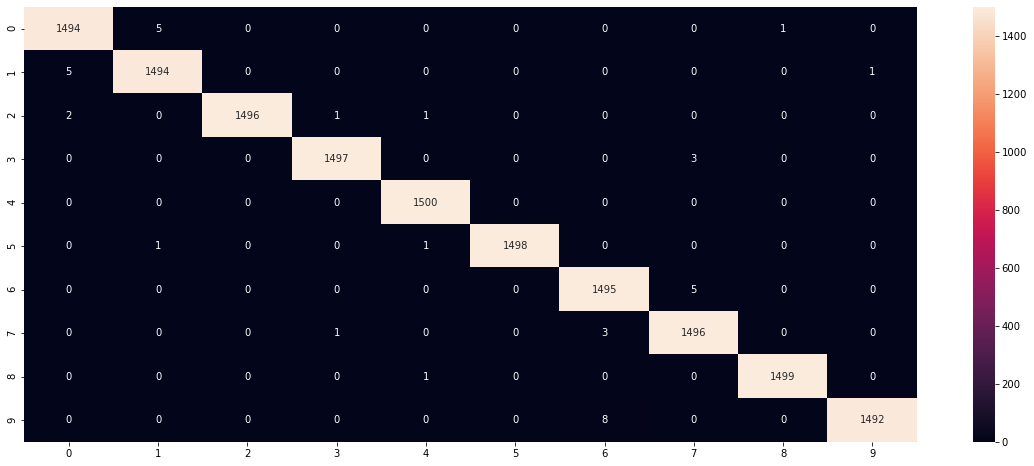




              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500
           2       1.00      1.00      1.00      1500
           3       1.00      1.00      1.00      1500
           4       1.00      1.00      1.00      1500
           5       1.00      1.00      1.00      1500
           6       0.99      1.00      0.99      1500
           7       0.99      1.00      1.00      1500
           8       1.00      1.00      1.00      1500
           9       1.00      0.99      1.00      1500

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [21]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(ytest, ypred)

plt.figure(figsize=(20,8))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

print("\n\n")
print(classification_report(ytest, ypred))

In [22]:
def create_sub():
    results = model.predict(testx)
    results = np.argmax(results,axis = 1)

    df_sub = pd.read_csv("../input/Kannada-MNIST/sample_submission.csv")
    df_sub['label'] = results
    df_sub.to_csv("submission.csv",index=False)

In [23]:
create_sub()